## Рубежный контроль №2 «Методы обучения с подкреплением»

- Студент — Коценко А.А.
- Группа — ИУ5-22М

Осуществите подбор гиперпараметров для одного из алгоритмов временных различий, реализованных в соответствующей лабораторная работе:

- **SARSA**
- Q-обучение
- Двойное Q-обучение

Критерием оптимизации должна являться суммарная награда.

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
import pygame
import gym
import os

pygame 2.4.0 (SDL 2.26.4, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
os.environ['SDL_VIDEODRIVER']='dummy'

In [3]:
pygame.display.set_mode((640,480))

<Surface(640x480x32 SW)>

In [4]:
# Базовый агент, от которого наследуются стратегии обучения
class BasicAgent:

    ALGO_NAME = '---'

    def __init__(self, env, eps=0.1):
        # Среда
        self.env = env
        # Размерности Q-матрицы и сама матрица
        self.nA = env.action_space.n
        self.nS = env.observation_space.n
        self.Q = np.zeros((self.nS, self.nA))
        # Значения коэффициентов, порог выбора случайного действия
        self.eps=eps
        # Награды по эпизодам
        self.episodes_reward = []

    def print_q(self):
        print('Вывод Q-матрицы для алгоритма ', self.ALGO_NAME)
        print(self.Q)

    # Возвращает правильное начальное состояние
    def get_state(self, state):
        if type(state) is tuple:
            # Если состояние вернулось с виде кортежа, то вернуть только номер состояния
            return state[0]
        else:
            return state

    # Возвращает действие, соответствующее максимальному Q-значению для состояния state
    def greedy(self, state):
        return np.argmax(self.Q[state])

    # Выбор действия агентом
    def make_action(self, state):
        if np.random.uniform(0,1) < self.eps:
            # Если вероятность меньше eps, то выбирается случайное действие
            return self.env.action_space.sample()
        else:
            # Иначе действие, соответствующее максимальному Q-значению
            return self.greedy(state)

    # Построение графика наград по эпизодам
    def draw_episodes_reward(self):
        fig, ax = plt.subplots(figsize = (15,10))
        y = self.episodes_reward
        x = list(range(1, len(y)+1))
        plt.plot(x, y, '-', linewidth=1, color='green')
        plt.title('Награды по эпизодам')
        plt.xlabel('Номер эпизода')
        plt.ylabel('Награда')
        plt.show()

    # Реализация алгоритма обучения
    def learn():
        pass

In [5]:
# Реализация алгоритма SARSA
class SARSA_Agent(BasicAgent):

    # Наименование алгоритма
    ALGO_NAME = 'SARSA'

    def __init__(self, env, eps=0.4, lr=0.1, gamma=0.98, num_episodes=20000):
        # Вызов конструктора верхнего уровня
        super().__init__(env, eps)
        # Learning rate
        self.lr=lr
        # Коэффициент дисконтирования
        self.gamma = gamma
        # Количество эпизодов
        self.num_episodes=num_episodes
        # Постепенное уменьшение eps
        self.eps_decay=0.00005
        self.eps_threshold=0.01

    # Обучение на основе алгоритма SARSA
    def learn(self):
        self.episodes_reward = []
        # Цикл по эпизодам
        for ep in tqdm(list(range(self.num_episodes))):
            # Начальное состояние среды
            state = self.get_state(self.env.reset())
            # Флаг штатного завершения эпизода
            done = False
            # Флаг нештатного завершения эпизода
            truncated = False
            # Суммарная награда по эпизоду
            tot_rew = 0
            # По мере заполнения Q-матрицы уменьшаем вероятность случайного выбора действия
            if self.eps > self.eps_threshold:
                self.eps -= self.eps_decay
            # Выбор действия
            action = self.make_action(state)
            # Проигрывание одного эпизода до финального состояния
            while not (done or truncated):
                # Выполняем шаг в среде
                next_state, rew, done, truncated, _ = self.env.step(action)
                # Выполняем следующее действие
                next_action = self.make_action(next_state)
                # Правило обновления Q для SARSA
                self.Q[state][action] = self.Q[state][action] + self.lr * \
                    (rew + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])
                # Следующее состояние считаем текущим
                state = next_state
                action = next_action
                # Суммарная награда за эпизод
                tot_rew += rew
                if (done or truncated):
                    self.episodes_reward.append(tot_rew)

In [6]:
# Проигрывание сессии для обученного агента
def play_agent(agent):

    env2 = gym.make('Taxi-v3', render_mode='human')
    state = env2.reset()[0]
    done = False

    while not done:
        action = agent.greedy(state)
        next_state, reward, terminated, truncated, _ = env2.step(action)
        env2.render()
        state = next_state
        if terminated or truncated:
            done = True

In [7]:
# Построение графика наград по эпизодам
def plot_rewards(x, y):
    fig, ax = plt.subplots(figsize = (15,10))
    plt.plot(x, y, '-', linewidth=1, color='green')
    plt.title('Награды')
    plt.xlabel('Параметр')
    plt.ylabel('Награда')
    plt.show()

In [8]:
def find_hyperparameters_sarsa():

    env = gym.make('Taxi-v3')
    rewards_eps = []
    rewards_lr = []
    rewards_gamma = []
    x = np.arange(0.1, 1, 0.1)

    for i in x:
        agent = SARSA_Agent(env,eps=i)
        agent.learn()
        agent.print_q()
        rewards_eps.append(np.asarray(agent.episodes_reward).sum())
    plot_rewards(x, rewards_eps)
    best_eps = x[rewards_eps.index(max(rewards_eps))]
    print(f"Best eps: {best_eps}")
    x = np.arange(0, 1, 0.03)

    for i in x:
        agent = SARSA_Agent(env, eps = best_eps, lr = i)
        agent.learn()
        agent.print_q()
        rewards_lr.append(np.asarray(agent.episodes_reward).sum())
    best_lr = x[rewards_lr.index(max(rewards_lr))]
    print(f"Best lr: {best_lr}")
    plot_rewards(x, rewards_lr)
    x = np.arange(0, 1, 0.03)

    for i in x:
        agent = SARSA_Agent(env, eps = best_eps, lr = best_lr, gamma = i)
        agent.learn()
        agent.print_q()
        rewards_gamma.append(np.asarray(agent.episodes_reward).sum())

    best_gamma = x[rewards_gamma.index(max(rewards_gamma))]
    print(f"Best gamma: {best_gamma}")
    plot_rewards(x, rewards_gamma)
    print(rewards_eps)
    print(rewards_lr)
    print(rewards_gamma)
    print(f"Best params: eps={best_eps}, lr={best_lr}, gamma={best_gamma}")

In [9]:
def run_sarsa(eps, lr, gamma):
    env = gym.make('Taxi-v3')
    agent = SARSA_Agent(env, eps=eps, lr=lr, gamma=gamma)
    agent.learn()
    agent.print_q()
    agent.draw_episodes_reward()
    play_agent(agent)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1079.94it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-4.41183996 -1.82543387 -2.81790586 -2.38988529  7.67368544 -4.50944461]
 [-1.31250811  0.80067434 -0.03112572  1.04874205 13.17803699 -1.77468333]
 ...
 [ 2.50486467 13.93066283  3.43505113  4.23879258 -2.10901221 -1.47234371]
 [-3.02880046 -2.9760972  -2.9130581   4.62476238 -3.72985139 -3.64822348]
 [-0.379278    8.60210167 -0.19       -0.19       -1.9        -1.9098    ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1155.64it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.88032111 -1.42523988 -3.95504785 -3.07245482  7.62430513 -6.65375483]
 [ 0.67384423  1.53332848  1.24742662  1.43200994 13.05142024 -3.72671868]
 ...
 [-1.1414068  10.4555702  -1.31306926 -1.41370342 -5.42280287 -3.79996163]
 [-3.87206303 -1.45549151 -3.86953041 -3.85996812 -4.45764084 -5.68730481]
 [-0.19       -0.19       -0.18006207 17.11377722 -1.9        -2.72862   ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1130.76it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.51767292 -2.24532133 -6.54582543 -1.67915433  8.0071599  -9.69291398]
 [-1.51982542  4.0452579  -0.244911    6.12506598 13.1107403  -4.51692388]
 ...
 [-1.85915495 -2.0455615  -1.86013363  3.49224854 -2.93844388 -6.76034572]
 [-3.98893854 -3.8170325  -3.86933594  0.3589754  -4.89723711 -8.053976  ]
 [-0.46179496 -0.3771604   1.12323552 18.15191265 -1.40064069 -1.84312888]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1028.21it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -5.74223737  -4.41896141  -6.26909489  -7.48051537   7.79713515
  -13.65549607]
 [  0.90989789   3.95136572  -1.43322928   3.90173636  13.09811139
   -6.53924905]
 ...
 [ -1.65522156  11.0137431   -0.6004735   -1.52235866  -7.19826136
   -6.2958758 ]
 [ -9.01246641  -8.54954025  -8.64848245  -1.36861321 -14.47043621
  -13.96980759]
 [  3.0393055    5.04364888   0.99020353  18.26490301  -2.84584877
   -2.05340014]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 899.56it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -9.85800592  -4.78301239  -8.20910722  -7.67484414   7.62713876
  -13.6210491 ]
 [  2.95442082   1.29221875  -0.6713961    4.39891443  13.18625582
   -5.57960241]
 ...
 [  1.65760383   9.58694155   0.67790598  -1.28514854  -7.08897056
   -8.22051809]
 [-12.63786677  -5.55958189 -12.82583488 -12.95418979 -18.71661088
  -18.9065124 ]
 [  8.15952744   6.01061346   9.18779881  18.05186071   2.2689685
    1.42211752]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:33<00:00, 598.41it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-11.94430035  -7.79958242 -12.45861306 -10.65382192   7.57729567
  -15.40717003]
 [ -1.33567394   1.02122863  -0.27262557   1.87351349  13.13963866
   -5.63019378]
 ...
 [  3.36306036  14.51686569   3.25620208  -4.20826412  -8.52948862
   -4.23063308]
 [-20.31911282 -19.70558576 -18.91953576  -3.19956479 -26.29841356
  -28.11753112]
 [ 10.11096891   3.56493677  10.89575883  18.48486452   2.0751216
    2.55139565]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:33<00:00, 595.48it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-19.08191771 -10.03646035 -15.76747333 -12.25804413   6.51610409
  -17.6586997 ]
 [  1.14834879   3.30931854  -2.47955461   4.63414926  13.04226759
   -7.60243742]
 ...
 [ -9.60678276   1.93188377 -10.50213489 -12.82881626 -17.6204553
  -19.69579951]
 [-26.36460847 -23.49491117 -22.8810653   -7.5376156  -34.58260386
  -35.85129988]
 [ 10.64570941   6.02798199  12.35244416  17.77463809   3.43571189
    2.39124805]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:46<00:00, 434.00it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-16.97254855 -11.77114553 -19.1961746  -13.64947803   8.0708139
  -18.40192201]
 [ -5.90117757   3.40894346  -1.61686059  -0.36001779  13.08236456
   -5.84927805]
 ...
 [-10.11317458   6.94011986  -9.00011445 -10.73187448 -25.82519345
  -25.45810154]
 [-36.74194213 -36.73524222 -33.71711997 -11.87364269 -49.69686627
  -45.47023644]
 [ 12.45833495   9.72632754  10.39084552  18.0032699    2.4764371
    4.91251188]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:06<00:00, 301.16it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-26.80019536 -19.09870676 -26.57643182 -12.24354908   6.80873018
  -24.77160851]
 [ -4.56354302   1.97606979  -2.66822661  -4.22532291  12.72467894
   -8.18556986]
 ...
 [-29.53935975   2.83012926 -29.52682369 -29.19246977 -37.4227109
  -38.46862196]
 [-46.32022348 -50.10179441 -49.94153582 -10.83563259 -53.92900916
  -55.64700277]
 [ 12.30747537   8.02576479  13.1758556   18.41955697   3.12974051
    4.04011732]]


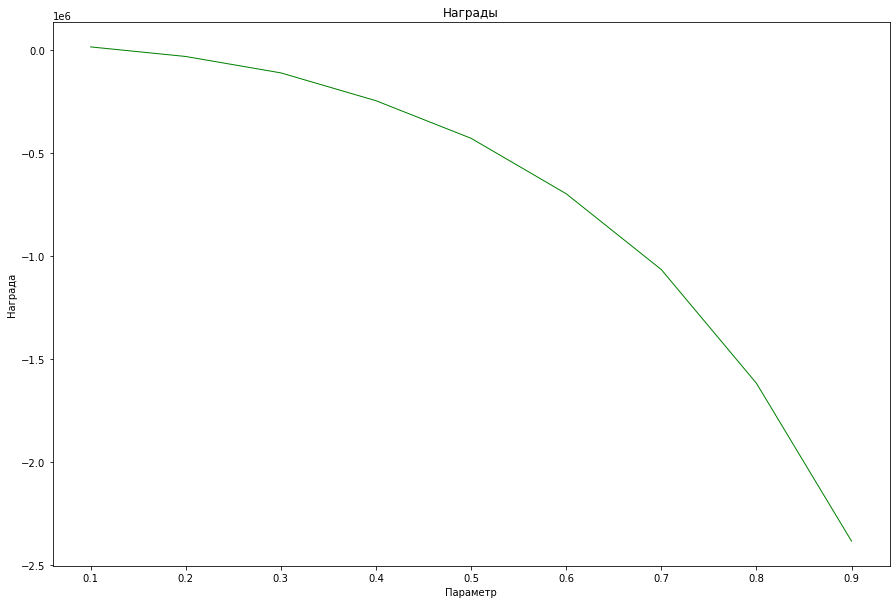

Best eps: 0.1


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [03:14<00:00, 102.91it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1026.17it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.12002942 -2.62017274 -3.40215657 -2.89603254  7.14469242 -4.21131773]
 [-1.81138167 -1.82795295 -1.82364124 -1.05244363 12.77270754 -1.89758647]
 ...
 [-0.9997671  -0.77071185 -0.98786326 -0.95283557 -1.46419403 -1.78018037]
 [-2.62989193 -2.62331936 -2.66297654 -2.2681585  -2.64273844 -2.88162949]
 [-0.088209   -0.059982   -0.0591      4.76693887 -0.591      -0.30173754]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1212.89it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.9486477  -3.71546022 -3.53790401 -0.59019634  7.60162335 -5.79359749]
 [-0.5864537  -0.17250375 -0.94483511  0.21225868 12.24545178 -1.92849623]
 ...
 [-0.91978681  2.6174776  -0.94063845 -0.94717675 -2.23215784 -2.25397414]
 [-2.69477802 -2.63115617 -2.68348209 -2.6080895  -2.82899539 -3.24573643]
 [-0.1164     -0.119928   -0.1164      6.57749045 -0.6        -1.167528  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1394.96it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-2.82410741 -2.30700998 -4.03870597 -1.53531691  7.55100542 -5.44825208]
 [-0.35469789 -0.90073254 -1.04113159  3.79120338 12.29941033 -2.00384075]
 ...
 [-1.45706294 -0.84707213 -1.38556594 -1.44595523 -3.29819605 -1.726938  ]
 [-2.96857259 -2.94425506 -2.99559619 -1.25497076 -4.03538442 -4.30159897]
 [-0.1719     -0.32421593 -0.254367   13.29649272 -1.719      -0.91516158]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1429.93it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.47062678 -2.79719372 -1.17961819 -1.3266431   7.48106845 -6.69586161]
 [ 2.86943827  2.5464012   0.22812236  2.15428682 12.31731696 -2.58220643]
 ...
 [-1.51485751  3.2151128  -1.67926728 -1.35713046 -3.34654455 -3.22645902]
 [-3.19784342 -2.6297237  -3.24547518 -3.14969243 -4.50601843 -4.51767303]
 [-0.45018209 -0.239712    0.42928036 15.62582482 -2.256      -2.270112  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1437.77it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.49119281 -0.97318469 -1.01142553 -2.01751559  8.02225505 -7.9117983 ]
 [-0.69173853 -0.37491608  1.6494119   2.52656748 13.06398206 -3.00477938]
 ...
 [ 5.56887099 14.48557278  5.27124016  2.28046538 -2.72892123 -1.92995377]
 [-3.17409709 -3.16068615 -3.32906557  1.72094596 -4.24734459 -3.99498152]
 [-0.82788817  7.53758583 -0.82811807 -0.7938     -1.5        -2.79705   ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1640.10it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.72125575  1.00573056  1.73432752  2.1104793   8.01553535 -3.91761356]
 [ 1.01968573 -2.8811974   2.95308622 -2.50512221 13.20869474 -2.96517998]
 ...
 [-2.39613464 -2.05244668 -2.29786312  4.15021613 -4.95344655 -4.73952977]
 [-3.99534128 -0.85313371 -4.09752197 -4.37593794 -4.87694597 -6.58790482]
 [-0.3276     -0.359352   -0.3276     18.54096317 -3.276      -3.307752  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1393.41it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.87062185  4.5087928  -3.89974851 -0.54452704  7.80834232 -4.44249338]
 [-0.84510373  5.26379986  1.94718438 -3.00002404 13.14557612 -2.15517237]
 ...
 [-2.01118866 10.13253684 -1.95903189 -1.78150942 -3.759      -3.93150803]
 [-3.35251508 -3.43311877 -3.42227789  1.17951276 -3.759      -5.18111244]
 [-0.3759     -0.419118   -0.58432122 17.5292317  -5.14697022 -2.1       ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1512.81it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-4.900468   -0.22748848 -5.04369619  0.66393902  7.78649506 -3.99867195]
 [ 2.04643171  0.52167599  4.23171133  2.53356206 12.71309717 -4.028553  ]
 ...
 [-1.67313961  5.79752128 -1.53224023 -1.71643338 -5.848733   -5.76576553]
 [-4.94394897 -4.08489169 -4.61398913 -4.7055732  -5.70958848 -8.48381214]
 [-0.4224     -0.54511524 -0.4224     15.84084534 -5.61024    -4.280448  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1699.07it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-0.97959198  4.85147668  3.81624929  1.29616017  7.82708659 -5.11326156]
 [ 6.14473397 -0.8677904   0.66858721  3.30062237 13.17225052 -2.06923096]
 ...
 [ 5.86826487 14.51386043 10.98958047  5.86155122 -4.54207618 -0.4463045 ]
 [-3.31566915 -0.50605735 -3.46838311 -3.6175795  -6.62171447 -7.76732178]
 [-0.4671     13.77539475 -0.610983   -0.4671     -7.61233232 -4.45465696]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1605.42it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.9733778   0.08495273 -0.38689186  4.55953111  8.01790436 -4.86731739]
 [ 4.77380886  1.34776051  4.00711508  4.7750916  13.0100562   1.84188357]
 ...
 [-2.90273907 12.66579867 -2.38727267 -2.46426445 -7.09571507 -3.72203601]
 [-3.82241731  2.19058361 -3.92309149 -4.02943578 -5.1        -5.1882    ]
 [-2.21814    -0.5982     -0.953058   18.48135844 -6.6582     -3.14994   ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1674.29it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.48743717   2.88742535  -5.27261121   0.32140261   8.24460831
   -9.61785558]
 [  5.4109419    7.2991767    4.5663987    6.58279774  13.26716523
    1.73347858]
 ...
 [ -3.06990829  -2.99682361  -3.0035712    3.71118915  -3.3
   -5.617722  ]
 [ -6.43773967  -5.29511923  -6.10392791   5.43067669  -7.80944209
  -11.1063742 ]
 [ -1.09612578  -0.657822    -0.87746274  18.46335031  -5.511
   -5.617722  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1702.80it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.75610401  -1.18790675  -5.71115945   1.27638383   8.31254969
   -7.28733409]
 [  0.94087561   6.69103957  -4.83857861  -5.0007634   13.24792495
   -4.56756493]
 ...
 [ -3.09327506  -2.73731552  -2.75656284   2.5555812   -7.71294666
   -3.6       ]
 [ -6.46298759  -6.5169291   -6.84290868   4.82808813  -9.50264202
  -10.44857966]
 [ -0.81914112  -0.75514813   5.74487269  18.59995329   0.
    0.        ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1686.44it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.32241667   1.56280815   2.16195156   1.06433707   7.99615829
   -4.80356169]
 [  4.55695494   4.68325668   3.57349336   4.14112252  13.2744333
   -1.7866847 ]
 ...
 [ -3.48231366   6.76088683  -2.9478365   -2.72459754  -6.428058
   -8.46408004]
 [-11.64922589   3.52178682 -10.76920509  -9.9422487  -17.0409809
  -13.78723485]
 [ -0.6279      -0.86788338  -0.6279      18.57369404  -6.279
   -6.428058  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1725.90it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-3.11266776  0.53034779  1.16819465  0.71292083  8.03779859 -4.5375285 ]
 [ 4.86095347  5.58344737  5.2418335   5.02028368 12.61596404 -0.33111047]
 ...
 [-3.42139505 -3.91604537 -3.13482863 11.06115291 -6.636      -6.808872  ]
 [-6.02274374  9.42485576  1.94449638 -6.19591844 -4.91643732 -7.31106951]
 [-0.6636     -0.42       -0.6636     18.53295584  0.          0.        ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1660.33it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.94433126  -1.78673516  -2.20016616  -0.38600973   7.57366625
   -3.61517437]
 [  0.42508203   3.01960422   1.82140125   3.64262297  13.21622808
    0.43578792]
 ...
 [  3.9015819    8.87090709   3.69056775  -2.10042778  -2.08192355
   -0.02733043]
 [ -4.63897019  -4.69958952  -4.98880784   1.31337927 -10.7755405
   -7.17345   ]
 [ -0.6975      -0.89595     -1.1412225   18.59039595  -7.17345
   -0.62819039]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1738.51it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -6.65602412   0.3302549   -1.31209046   0.49717735   7.71527393
   -4.00883662]
 [  5.94811307   7.15553851   5.67131377   2.02660215  12.75436025
    1.5571885 ]
 ...
 [ -2.78380772   8.56825101  -2.29039896  -2.51008549  -5.025792
   -7.521792  ]
 [ -6.08263113   2.76444751  -6.08944425  -6.14870877 -10.34926991
   -9.82912781]
 [ -0.7296      -0.955392    -0.7296      18.59957663 -12.0259584
   -7.521792  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1566.51it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.42195828e+00  3.10685438e+00  2.27784260e+00  9.81481925e-03
   8.36234305e+00 -6.86743424e+00]
 [ 3.11243467e+00  2.90168370e+00  6.19360980e+00  1.87004200e-01
   1.32744558e+01 -5.50667540e+00]
 ...
 [ 2.25978932e+00  1.42339299e+01  4.95183212e+00  1.41105667e+00
   2.87151756e+00  5.42556150e-01]
 [-4.49650426e+00  4.57593453e+00 -4.92643322e+00 -4.59243026e+00
  -9.33070604e+00 -5.35355953e+00]
 [-7.59900000e-01 -1.13969802e+00 -7.59900000e-01  1.85981795e+01
  -8.59719605e-02 -5.10000000e+00]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1510.19it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [  1.71932218   1.3440786    1.4259547    3.85400567   8.36234335
   -3.96476373]
 [  3.98194756  -4.06182108   7.63317622   0.47464432  13.21807725
    2.82655158]
 ...
 [ -1.91718587  12.24050929   1.11578414   1.64220627  -2.75845223
    1.4396791 ]
 [ -6.19328968  -5.64730117  -6.58937511   5.33667734 -10.76312087
  -13.47758912]
 [ -0.7884      -1.074168    -0.7884      18.58232971  -7.884
   -8.169768  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1534.80it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.69578959  -4.41143759  -4.61795746  -0.65848134   7.87862795
   -6.18565018]
 [ -0.9083669   -0.86472136  -0.78705583   1.83692862  13.27326585
   -6.92057294]
 ...
 [ -2.48952565   9.67346009  -2.66605615  -2.69662045  -8.11566127
   -8.469402  ]
 [ -6.25782521   4.65271383  -4.56182361  -4.62336277  -5.7
  -10.64471873]
 [ -0.920493    -1.40732772  -1.02531486  18.59994648  -8.151
    0.72643668]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1595.75it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.15494427   3.26431615  -2.4510219   -2.28463444   8.3428431
   -5.89054286]
 [  2.21648869   2.16992159   1.87952914   2.50421619  13.22038254
    0.27141942]
 ...
 [ -6.80837036  -8.17363328  -8.5730999    0.39489343 -11.26174962
  -13.24603103]
 [-12.49307351   2.13086735 -10.73721451  -8.24922007 -16.63966962
   -8.7528    ]
 [ -1.665888    -1.62434496  -1.95631296  18.6         -8.4
    5.895072  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1579.17it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.68518931  -6.61592032  -6.92262368  -4.23074919   8.33393058
  -12.19651454]
 [ -3.12763509   1.4385072    4.68500698   8.14797809  12.67624401
   -3.28768892]
 ...
 [ -1.5333554   11.66306487 -11.30723616  -1.34341049 -13.02411566
   -8.55813115]
 [ -7.77926549  -6.91612325 -10.09517208  -7.65541349 -11.69449695
  -14.48617315]
 [ -0.8631      -0.63        10.534293    18.6          5.87243144
   -6.688962  ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1565.24it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -0.31062582  -0.40347412  -5.66806657   1.4219996    3.91186452
  -12.17216549]
 [ -0.10547839   2.69937555   0.55479509   5.4439071   13.27425474
    1.43524904]
 ...
 [  4.41742822  11.40091018  -5.56351042  -4.50572753 -10.22833817
  -10.44747447]
 [ -7.99049307  -7.9703162   -7.65330352   4.32884455 -10.87079362
  -14.57916207]
 [ 14.27776145   6.44460509   9.49116834  18.59999993   7.00684402
    7.99415604]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1533.23it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-10.22184743 -10.36534108  -6.92833814  -9.6341269    7.08588762
   -6.47353814]
 [ -3.91597987  -3.3647521   -3.8232032   -4.5098183   13.2641462
   -3.89783589]
 ...
 [ -2.79335089  13.6853417    2.41147715   3.19676809   0.02940072
    0.19370355]
 [-10.36109726 -10.33550526 -10.78776789  -9.22792924 -17.96740499
  -11.16908785]
 [ -0.9039      -1.370478    -0.9039      18.59961108  -9.039
    1.47707222]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1403.08it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-14.76742342  -9.95390194 -10.41127852 -12.03440549   7.6457277
  -14.55924903]
 [ -6.94317651  -1.50463238  -7.36806858  -7.38663294   7.58578561
   -3.35729928]
 ...
 [ -4.11781465  -3.36773461  -3.51962803  -0.17892361  -9.64558397
  -12.27458176]
 [ -0.25887503   8.89103927  -1.74115941 -17.98689653  -6.59310471
  -26.34027302]
 [ 10.09784142   1.86957378  11.08232782  18.6          7.84506931
    8.11765659]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1444.99it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -7.53120813   2.9095717  -15.04197415 -10.6611529    8.36234335
  -15.32259528]
 [-11.97419233   5.88570569 -11.95260524 -12.52816852  13.27445576
  -12.76041812]
 ...
 [ -3.4019695   12.00896664   6.11876929  -6.35386496  -0.82672296
  -13.92267091]
 [-12.94941334 -12.54236005 -12.71706696 -12.15503364 -18.77011429
  -20.73384812]
 [ 13.25163735  -1.48875      9.9602787   18.6          7.1278125
    8.1452646 ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1417.09it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -9.40898932 -13.89609424 -12.09076449 -12.30091535   8.34368486
  -18.34246765]
 [ -5.30429869   2.05468913   2.13704426   8.60614244  13.26675289
    0.14250004]
 ...
 [ -7.91770593  -8.50555906  -7.74758463   5.83153316 -10.15436433
  -10.57226432]
 [-22.82292954 -24.00455564 -23.35550085   3.51731134 -26.63838353
  -27.03316936]
 [  2.37231539   1.4257085   13.25888503  18.6          4.19314896
    4.70184   ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1321.06it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-11.60881249 -10.77375756 -14.57820042 -16.65224622   8.30806025
  -18.32371888]
 [-12.02446183 -12.16258593 -13.5169162  -12.21335107  13.27445507
  -13.9278417 ]
 ...
 [ -6.47619551  14.5657712   -3.28035609  -7.86221837 -13.28532742
  -13.78651776]
 [-18.7573663    8.66036388 -13.68996252 -17.41155049 -15.29409299
  -17.8730117 ]
 [ -1.90921794   0.8219561   -1.90921794  18.59999964   8.20387761
    8.00959151]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:15<00:00, 1331.95it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-14.82418351 -16.79935234 -18.01497385 -18.53934561 -10.68281935
  -22.20274678]
 [-10.19399853 -14.26621517 -14.10985025 -17.21148804  13.27238639
  -11.34813637]
 ...
 [ -8.14159783  14.56499113  -8.29654938  -6.50070492 -15.88292897
  -13.08090792]
 [-18.50405688 -15.12064119 -14.71495589 -19.45361184 -19.58590168
  -16.73814377]
 [ 13.8951832    2.65968897  16.87549282  18.6          5.48183408
    7.75021471]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:16<00:00, 1219.17it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-14.86262204 -24.31159741 -24.3345805  -24.08818698   8.31490124
  -23.93372338]
 [  1.83196219  -9.8969384   -9.90121456 -14.84457954  10.76810072
  -10.09831541]
 ...
 [-12.75731576  10.24718643 -13.422455   -13.63596316 -15.31317677
   -4.89924607]
 [-26.08414341   6.86710498 -26.0328036  -26.33022008 -35.35712918
   -4.78801886]
 [ 15.83537517   2.47956286  15.88404823  18.6          6.83129048
    6.77005465]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1116.01it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-16.97435834 -28.33470881 -16.6892252  -28.19261964   8.36212429
  -19.697144  ]
 [-18.56340423 -20.68159327 -17.65453746   3.50011251  10.76878733
  -19.77735758]
 ...
 [-13.43589365 -15.12841191 -13.67025121 -13.19288842 -18.62693223
  -19.72935361]
 [-32.31516005 -34.04105904 -32.43127671   1.22779046 -34.81136189
  -33.6352473 ]
 [ -9.99674278 -11.0295105   -7.52661215  18.6         -9.9
  -12.82959388]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 903.56it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-34.16841518 -34.01132197 -34.22565759 -34.03688988   8.36234334
  -42.13711115]
 [-30.73266911 -19.65231468 -18.50914759 -19.03643937  13.27445578
  -23.42678013]
 ...
 [-14.24524783  14.5657712  -14.3164184  -19.25313377   2.13619509
  -17.86781917]
 [-32.06999035   0.40730648 -32.02850284 -31.80734892 -29.4376792
  -37.09911487]
 [  7.95135058  15.19974649   6.79295728  18.6          8.13766882
    6.8306434 ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:26<00:00, 745.81it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [-41.52564656 -37.74584592 -40.7794534  -40.18637253   8.36234281
  -47.22835658]
 [ -1.37061106 -16.0979215  -25.95767314  10.47371619  13.27445578
  -31.48433715]
 ...
 [-16.48245957  14.5657712  -13.48567463 -19.95850052 -17.78057909
  -20.64732682]
 [-38.14679013 -39.57845079 -41.98428991 -38.13681844 -44.34778561
  -39.52099252]
 [ 16.45980544  -2.9753191    7.26147344  18.6          1.02091184
    7.46140887]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:35<00:00, 567.76it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [  5.52375229 -45.7088438  -45.79990428 -45.78480353   8.36233817
  -44.84718126]
 [-32.93361585  11.54838504 -34.28307862 -40.68285453  13.27444659
  -40.2368878 ]
 ...
 [-24.72684381  14.5657712  -24.8065165  -25.01407923 -29.35829543
    3.89532842]
 [-47.70068978 -52.57137279 -47.68006838 -47.75090519 -51.5464416
  -51.53605255]
 [ 17.1136079   13.04058905  14.60248001  18.6          8.04573
    8.01936768]]
Best lr: 0.3


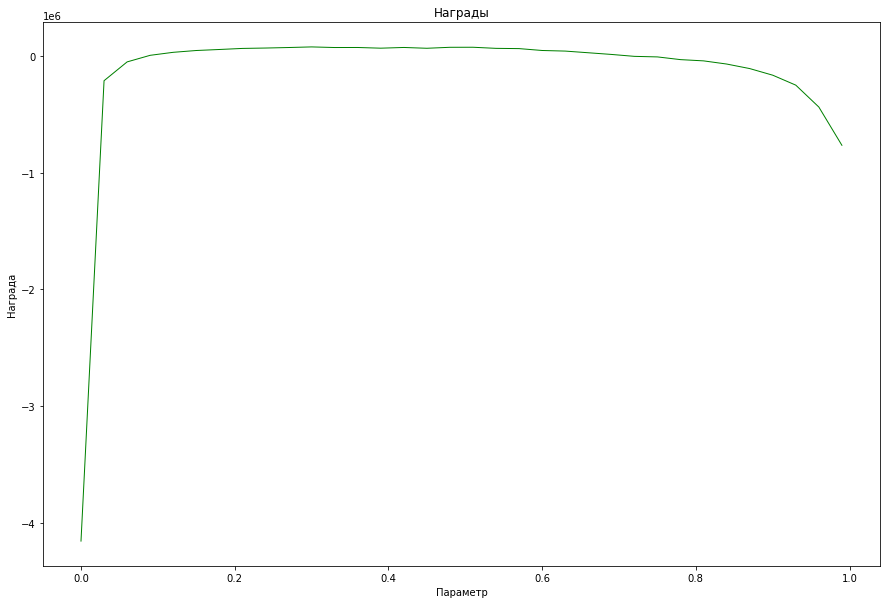

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [02:18<00:00, 144.70it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.         -1.         -1.         -1.         -1.         -8.3193    ]
 [-1.         -1.         -1.         -1.         -1.         -8.3193    ]
 ...
 [-1.         -1.         -1.         -1.         -8.82351    -8.82351   ]
 [-1.         -1.         -1.         -1.         -8.82351    -8.82351   ]
 [-0.99321777 -0.99321777 -0.99321777 -0.9903111  -8.3193     -5.1       ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:46<00:00, 187.61it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.07058328  -1.05871525  -1.0309279   -1.11192788  -1.11185817
  -10.03112973]
 [ -1.04411194  -1.04453105  -1.1067008   -1.1118802   -1.03321588
  -10.02728315]
 ...
 [ -1.11067634  -1.03142204  -1.08701767  -1.11182914  -9.96384458
   -9.83281067]
 [ -1.10448595  -1.03092803  -1.10937925  -1.08748811  -9.20264075
   -9.83333762]
 [ -0.767703    -0.77466224  -0.7677273   -0.46379077  -7.60581304
   -6.57549556]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:40<00:00, 199.00it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.1772601   -1.22585712  -1.22578818  -1.22620821  -1.07036777
  -10.06491705]
 [ -1.14124909  -1.22579728  -1.06382979  -1.22582491  -1.22558411
  -10.06500872]
 ...
 [ -1.22230001  -1.0638298   -1.22221348  -1.22588307  -9.9285759
   -9.99559246]
 [ -1.11583557  -1.10305235  -1.11891774  -1.06407066  -9.47835192
   -9.99631869]
 [ -0.9641152   -0.99550456  -0.67077889   0.05370625  -5.09640015
   -5.1054    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:50<00:00, 180.62it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.14145746  -1.18470231  -1.21809367  -1.34196704  -1.10015683
  -10.10087259]
 [ -1.0989011   -1.34206317  -1.34271323  -1.27019524  -1.34162075
  -10.10379351]
 ...
 [ -1.3260519   -1.14512219  -1.30954123  -1.33938769  -8.38452442
   -9.81678747]
 [ -1.15925374  -1.21624246  -1.21687049  -1.10212722 -10.07967957
  -10.0921549 ]
 [ -0.783309    -0.68078669  -0.7835277    0.79632114  -5.1
   -5.1081    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:47<00:00, 185.62it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.16273204  -1.17446548  -1.19078122  -1.36274223  -1.13700786
  -10.1369845 ]
 [ -1.45880918  -1.29520345  -1.18839409  -1.16307331  -1.1358377
  -10.13954351]
 ...
 [ -1.32019846  -1.27413957  -1.33900159  -1.13636406  -8.93107677
   -8.94346385]
 [ -1.46631251  -1.44549415  -1.36115952  -1.13660495 -10.11890164
  -10.11728406]
 [ -0.791112    -0.81117989  -0.7915008    1.4         -5.1
   -6.52716   ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:44<00:00, 190.96it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.46093703  -1.58239786  -1.58529947  -1.58187215  -1.17647003
  -10.20367909]
 [ -1.36606634  -1.58082055  -1.55494997  -1.57794962  -1.17646865
  -10.17369707]
 ...
 [ -1.56264907  -1.16575183  -1.5692979   -1.4565246  -10.04707725
   -9.32751549]
 [ -1.57757724  -1.58053608  -1.57914771  -1.18535705 -10.14663307
  -10.1574133 ]
 [ -0.51        -0.91494184  -0.51         2.          -6.48
   -5.1135    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:37<00:00, 204.67it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.56190956  -1.33730464  -1.38786798  -1.45910692  -1.22568128
  -10.23413824]
 [ -1.44848255  -1.70234094  -1.38272078  -1.55456204  -1.21938961
  -10.21206262]
 ...
 [ -1.49327335  -1.38956852  -1.42258088  -1.22263828  -9.35546445
   -9.36552762]
 [ -1.55947776  -1.22392212  -1.70402951  -1.56208642 -10.22272938
  -10.22956918]
 [ -0.51        -0.5262      -0.51         1.76036762  -5.1
   -5.1162    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:39<00:00, 201.41it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.59353645  -1.47059043  -1.83601563  -1.46612216  -1.26582211
  -10.39691755]
 [ -1.6611329   -1.66229223  -1.66430454  -1.83397529  -1.25714001
  -10.2738522 ]
 ...
 [ -1.7237998   -1.2245175   -1.73828985  -1.84593989  -9.82743526
   -9.8383775 ]
 [ -1.80613125  -1.28827498  -1.82743518  -1.83345708  -9.98636311
  -10.24673462]
 [ -0.51        -0.5289      -0.51         3.19828665  -5.1
   -5.1189    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:37<00:00, 204.71it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.38536249  -1.31578947  -1.60315555  -1.96822333  -1.96809018
  -10.32342595]
 [ -1.64315384  -1.75864377  -1.91354222  -1.9545127   -1.29911696
  -10.26037189]
 ...
 [ -1.50651437  -1.24583056  -1.58085086  -1.53066     -6.68354183
   -7.77112918]
 [ -1.63527489  -1.76151294  -1.95641225  -1.33174099 -10.35940722
  -10.30795181]
 [ -0.6786      -0.5316      -0.69372      3.51755446  -5.1
   -5.13672   ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:38<00:00, 202.97it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.55001675  -1.72795508  -1.55002011  -1.74215457  -1.36997928
  -10.37872616]
 [ -1.88555159  -2.1074066   -1.73436524  -1.8835866   -1.33925152
  -10.42869731]
 ...
 [ -1.72797234  -1.88579762  -1.65124093  -1.36404715  -7.79926383
   -9.52483026]
 [ -2.06570641  -2.06787424  -2.09008334  -1.3820066   -9.83980879
  -10.32184887]
 [ -0.51        -0.9231      -0.51         4.00363171  -5.1
   -5.1243    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:44<00:00, 192.05it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -1.43071569  -1.70948934  -1.83780007  -1.99586843  -1.88014423
  -10.43950698]
 [ -1.84317457  -1.82828719  -2.00369209  -2.24450225  -1.37714896
  -10.48630948]
 ...
 [ -1.88219238  -1.26143003  -1.74502889  -2.21157046  -9.17024599
   -6.70483193]
 [ -2.24243318  -2.794842    -2.24167656  -1.48046661 -10.47540681
  -10.48176011]
 [ -0.327        0.           0.           3.92565599   0.
    0.        ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:34<00:00, 212.72it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.38939636  -2.38630386  -2.3934697   -2.12094216  -1.49160867
  -10.60722745]
 [ -1.8046517   -2.38409567  -1.49306354  -2.1223981   -1.89067298
  -10.50970065]
 ...
 [ -1.85628936  -1.72479695  -1.70873985  -1.51446065  -8.62898363
   -9.19383959]
 [ -1.86101156  -1.5033324   -2.25592456  -2.38926373  -9.21398386
   -9.87297962]
 [ -0.51        -0.5397      -0.51         5.6         -6.09866328
   -5.1297    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:33<00:00, 213.28it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.03204629  -2.04638228  -2.54693726  -1.90479784  -1.56057762
  -10.57516889]
 [ -2.23029668  -1.89533581  -1.90945254  -2.04247904  -1.54708606
  -10.61469928]
 ...
 [ -2.12126463  -1.91833378  -1.81807154  -1.57554617  -7.88930584
   -8.70113485]
 [ -2.53920323  -2.49171795  -2.54187583  -1.56251855 -10.66797898
  -10.66349049]
 [ -0.2278752   -0.62526735   0.21008726   6.2         -5.9004
   -5.1324    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:28<00:00, 227.04it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.70610622  -2.38665193  -2.69967014  -2.7021933   -1.65004672
  -10.76117773]
 [ -2.17367934  -2.38881334  -2.15429551  -2.16823154  -1.44410516
  -10.69426701]
 ...
 [ -1.9698685   -1.88545493  -2.53360805  -1.6738381   -9.75608675
   -9.98933107]
 [ -2.3939741   -2.63794974  -2.16407266  -1.6579576  -10.6670803
  -10.64762823]
 [ -0.51        -0.5451      -0.51         6.66872824  -5.1
   -5.1351    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:26<00:00, 230.92it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.88249614  -2.52645273  -2.85626896  -2.52859809  -1.76507508
  -10.8362449 ]
 [ -2.84727967  -2.52083104  -1.76770864  -2.53669147  -2.8069425
  -10.85938322]
 ...
 [ -2.5062821   -1.05460531  -2.50572524  -2.83323598  -8.77041242
   -9.97006937]
 [ -2.74431461  -1.77842993  -2.48942216  -2.57454971 -10.34165098
  -10.66512147]
 [ -0.51        -1.1526      -0.51         6.12641563  -5.1378
   -5.1378    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 244.94it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.39911458  -2.6963874   -1.81988977  -3.06091871  -3.17829654
  -10.94478277]
 [ -2.2262473   -2.40292659  -2.03074208  -2.26319238  -1.42757635
  -10.56792206]
 ...
 [ -2.17029706  -0.92978094  -2.62842847  -1.81146044  -8.02241867
   -8.72132917]
 [ -3.01518096  -1.78200736  -2.67059611  -2.42986701 -10.79073432
  -10.76258719]
 [ -0.876945    -0.6195111   -0.876945     5.08107     -5.1405
   -5.1405    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:19<00:00, 250.08it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.85187896  -3.24032567  -2.24429491  -2.38996418  -1.89576611
  -10.9895652 ]
 [ -2.49729326  -2.69992794  -2.80870792  -2.65186769  -1.43431463
  -10.62886345]
 ...
 [ -1.5719515   -0.80256917  -1.53112511  -1.4836592   -7.89967763
   -6.71643078]
 [ -2.51665223  -2.72096341  -2.53465375  -2.05095655 -10.88516355
  -10.91361507]
 [ -0.73044     -0.5532      -0.51         8.34753809  -5.1
   -5.1432    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:14<00:00, 269.48it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.55641717  -2.49929375  -2.37842004  -3.04100663  -2.02750979
  -11.50958914]
 [ -2.4902001   -3.36625627  -3.31120863  -2.98005829  -1.40131324
  -10.8417969 ]
 ...
 [ -1.8099655   -0.58194066  -1.6997176   -1.8918846   -5.1
   -7.8854244 ]
 [ -2.6661848   -3.04137372  -3.08643045  -1.98472573 -11.03613704
  -10.9428114 ]
 [ -0.594576    -0.5559      -0.657        7.54592559  -5.1
   -5.1459    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:08<00:00, 291.09it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -2.53195325  -2.93974782  -2.37238715  -2.35330099  -2.14174728
  -11.20286022]
 [ -3.16123872  -2.97965823  -3.10999797  -2.23079359  -1.17493031
  -10.75619548]
 ...
 [ -1.70537773  -0.30663674  -1.55930004  -1.75803443  -9.05774334
   -9.07549348]
 [ -3.10596222  -2.04558021  -3.09000307  -2.97990169 -10.81154914
  -10.71220555]
 [ -0.73962     -0.5586      -0.73962      9.53612029  -5.1
   -5.1486    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:10<00:00, 285.38it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.4273901   -3.17374074  -3.93317473  -3.42695239  -2.23837401
  -11.40538727]
 [ -2.3193404   -2.31838656  -2.24579901  -2.31877642  -0.98783256
   -8.81652824]
 ...
 [ -1.71486167  -0.03525217  -1.78272164  -1.7338004   -3.
   -6.74946212]
 [ -3.0525196   -3.36997486  -2.46860655  -2.40038768 -10.93574104
  -10.34591627]
 [ -0.51        -0.51        -0.51         9.83020707  -3.
   -5.1513    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:02<00:00, 321.26it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.65996264  -4.19547782  -3.36526898  -4.18947777  -2.29447015
  -11.93545396]
 [ -2.21359976  -2.20244323  -2.21375464  -2.25369488  -0.8820388
   -9.90905914]
 ...
 [ -1.66855563   0.41585424  -1.97580734  -2.83337646  -8.19817103
   -6.93621224]
 [ -3.37253638  -2.5686826   -2.95809805  -2.77889563  -5.55
  -10.33224921]
 [  1.11065947  -1.43772     -0.51        10.99976228  -3.
   -5.154     ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:56<00:00, 351.30it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.88256548  -4.43889938  -3.70116766  -3.87882492  -2.3504
  -12.01977344]
 [ -2.47318841  -1.92956871  -4.35292079  -2.19618837  -0.54774646
  -10.8083152 ]
 ...
 [ -2.31208521  -1.28540681  -2.02666639  -2.3722364   -3.
   -8.11724036]
 [ -2.7771464   -2.21194006  -3.33579793  -2.87178752 -11.15033408
  -10.55810371]
 [  0.69523141  -0.5667      -0.08825704  11.42059943  -5.1
   -5.1567    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:50<00:00, 399.85it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.66317043  -2.95596657  -4.60417574  -3.8644016   -2.41195796
  -11.6208057 ]
 [ -3.22443283  -3.63880136  -3.71853773  -2.92408679  -0.15583761
  -10.60410981]
 ...
 [ -3.06259325  -3.12947681  -2.70681156  -1.87017241  -5.1
   -8.10587177]
 [ -2.77044661  -2.13528721  -2.93312356  -2.89194079  -5.1
   -9.39459893]
 [ -0.51        -0.3         -0.51        12.13025858  -3.0594
    0.        ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:45<00:00, 441.23it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.55080916  -5.00712537  -4.37247042  -5.04260693  -2.42155966
  -12.19341523]
 [ -2.07327143  -1.68358031  -2.62329334  -1.77109059   0.29042807
   -8.29185547]
 ...
 [ -1.889499     1.73902035  -2.0866118   -1.94517642  -7.87187195
   -5.1621    ]
 [ -2.90922913  -2.07967457  -3.76276555  -2.94127945  -8.60635656
   -7.14938107]
 [ -0.51        -0.3         -0.51        12.79998247  -4.2082777
   -3.0621    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:38<00:00, 521.33it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.69451999  -3.91355806  -3.46919383  -3.7224729   -2.35146802
  -12.03438255]
 [ -2.29998243  -1.84489146  -2.48996829  -1.7181648    0.95102351
   -8.04724755]
 ...
 [ -1.89418816  -1.29761127  -1.75115821  -1.71325838  -6.72552
   -5.27550432]
 [ -2.70680657  -2.12838338  -2.5827172   -3.27672004  -6.95307726
   -5.1648    ]
 [ -0.947172    -0.76716     -0.947172    12.92165641  -6.6348
   -4.1016    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:31<00:00, 632.90it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.00573034  -4.02188438  -4.84773708  -3.99999977  -2.21315962
  -11.05489548]
 [ -1.86734703  -1.6299976   -1.96827587  -0.71793109   1.67729795
   -8.08620891]
 ...
 [ -1.987725    -2.69322592  -2.02994579  -2.28389971  -6.68475
   -5.1675    ]
 [ -3.95553914  -4.31603476  -4.63724787  -2.92103706  -7.38276745
   -9.72395753]
 [ -0.9701625   -0.888525    -0.657        8.98371075  -5.21475
   -5.1675    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:22<00:00, 898.00it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -4.76877257  -3.26412114  -4.17404824  -4.30993504  -1.96876568
  -11.05975666]
 [ -1.03241999  -0.50954771  -0.89741373   0.27985615   2.53808694
   -6.69034093]
 ...
 [ -1.75933843   1.44502273  -1.81377823  -1.51940221  -5.1
   -5.19137014]
 [ -3.90419624  -3.88750935  -3.94332162  -2.12597455  -9.87554439
   -5.1702    ]
 [ -0.51        -0.51        -0.5802      14.41029132  -5.1
   -5.1702    ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:17<00:00, 1121.36it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-4.17491115 -4.25413235 -4.20387888 -4.23970327 -1.47219535 -9.65798685]
 [-1.67680917 -2.89699056 -2.64690496  0.61555632  3.51941916 -7.24778723]
 ...
 [-1.90160442  2.72194613 -3.19763104 -1.91952785 -8.1009426  -7.08678911]
 [-2.96281018 -1.59160832 -2.74269843 -2.52158462 -7.03735914 -5.1729    ]
 [-0.657      -0.5829     -0.51       14.91819139 -5.1        -4.62441564]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:14<00:00, 1378.11it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[  0.           0.           0.           0.           0.
    0.        ]
 [ -3.33826784  -3.39687908  -3.36642519  -3.47464647  -0.78966855
   -9.8690626 ]
 [ -0.55269188  -0.1567181   -0.64097246   1.5905724    4.70713637
   -6.13563122]
 ...
 [ -2.45919292   0.42694262  -2.49789017  -2.46903949  -5.1
   -7.18352741]
 [ -3.6370051    0.21053539  -2.84422754  -3.84912167  -9.61032925
  -10.30796626]
 [ -0.51        -0.5856      -0.51        15.75070831  -5.1
   -4.47279789]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1515.85it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.60953417e+00 -2.33633111e+00 -5.33235235e+00 -2.04649941e+00
  -5.23193527e-03 -1.00939330e+01]
 [ 2.58186289e-01  2.31623363e+00 -2.25181978e+00  2.13001159e+00
   5.19207755e+00 -6.08734178e+00]
 ...
 [-2.64601892e+00  1.81453062e+00 -2.46226413e+00 -2.19629472e+00
  -6.97668892e+00 -6.94457687e+00]
 [-5.22633247e+00 -5.19656581e+00 -5.27180829e+00 -3.85277014e-01
  -9.86723614e+00 -7.98668537e+00]
 [ 1.21314530e+01  7.75425044e+00  1.15605995e+01  1.63999999e+01
   4.18184467e+00  3.85228735e+00]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1642.71it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-6.26796375 -2.24211592 -3.53000978 -4.54153968  1.17889966 -8.86106081]
 [ 1.53299698  1.61368424  1.11769611  3.71274198  7.5671259  -3.59381289]
 ...
 [-1.8979139   4.47261774 -1.97926881 -1.60371911 -5.1        -6.89186087]
 [-4.18415738 -4.0304362  -4.67959188  1.66270708 -5.1        -8.94278088]
 [-0.51       -0.381      -0.51       16.9741245  -5.1        -5.181     ]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:18<00:00, 1085.08it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-1.94496505 -0.52497015 -2.25092298 -0.62171478  2.9393103  -6.98753304]
 [ 2.37662158 -4.9283348  -0.92011303 -4.00492402  7.5360855  -4.38035371]
 ...
 [-3.05291104  3.48546785 -1.79599642 -2.09918798 -8.8915791  -6.31903191]
 [-4.351914   -1.8696868  -4.11810496 -4.03715972 -5.91530159 -5.1837    ]
 [-0.51       -0.5937      3.00291639 17.59749659 -5.1        -5.1837    ]]


100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [00:25<00:00, 777.09it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.07533170e+00  3.04122074e+00  1.10772842e+00  1.33736356e+00
   5.97539626e+00 -8.60804323e+00]
 [ 4.70477981e+00  5.95307807e+00 -4.38279862e-01  6.98385241e+00
   1.12375702e+01  4.99782275e-03]
 ...
 [-2.16440899e+00 -3.52286813e+00 -2.09327700e+00  5.92899589e+00
  -5.39075369e+00 -5.18640000e+00]
 [-4.31933885e+00 -7.00967779e-02 -4.01595856e+00 -3.96891414e+00
  -7.69984782e+00 -7.09989259e+00]
 [-7.43400000e-01 -5.96400000e-01 -5.10000000e-01  1.72322938e+01
  -5.10000000e+00 -5.18640000e+00]]


100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:13<00:00, 1442.55it/s]

Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 1.30379341  3.19408371  2.15488541 -3.67560308  8.77465103 -2.84336954]
 [-0.64693624  6.87577562  4.16346595 -2.51543197 14.11846036  2.09851383]
 ...
 [-2.3446341   9.23174157 -2.4123035  -2.22268915 -5.1        -5.75418023]
 [-3.80223742  0.10405831 -3.74765576 -3.57909789 -5.1        -5.1891    ]
 [-0.51       -0.5991     -0.51       18.63017294 -5.1891     -5.1891    ]]
Best gamma: 0.96


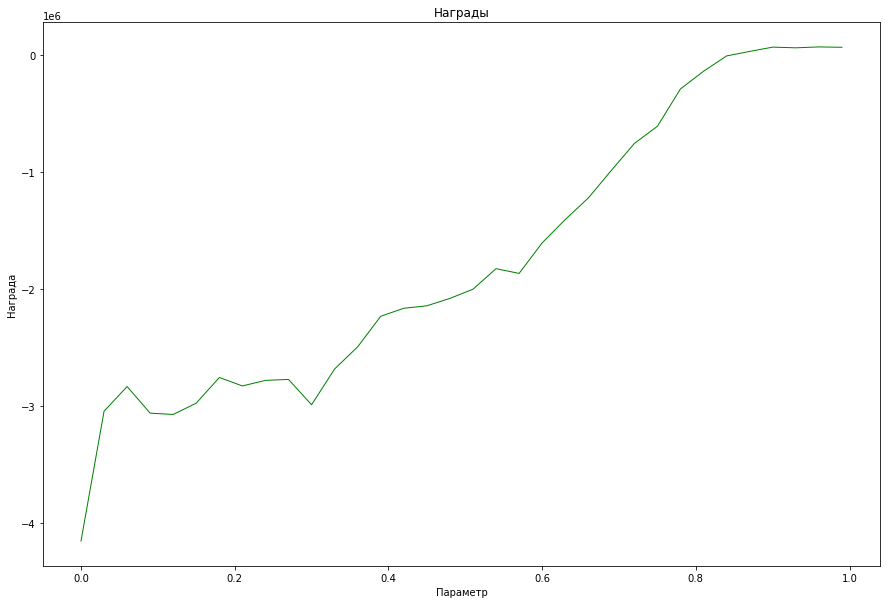

[14142, -32243, -111804, -246706, -429068, -697757, -1065533, -1616663, -2382133]
[-4158616, -211697, -50475, 6043, 31717, 47258, 55964, 65089, 68380, 72839, 78078, 72824, 73140, 67182, 73343, 66368, 74749, 75152, 65666, 63526, 47404, 42284, 27991, 13624, -2884, -7666, -30935, -41606, -68687, -107576, -164415, -249704, -437452, -765466]
[-4153908, -3042978, -2832007, -3059662, -3070663, -2973689, -2754620, -2826763, -2779130, -2771184, -2987698, -2681683, -2492106, -2230560, -2162489, -2141346, -2078094, -1999499, -1823799, -1864313, -1603469, -1403852, -1219344, -983589, -752832, -605573, -286093, -135291, -3925, 34398, 71107, 65275, 73024, 69702]
Best params: eps=0.1, lr=0.3, gamma=0.96


In [10]:
find_hyperparameters_sarsa()

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:11<00:00, 1679.08it/s]


Вывод Q-матрицы для алгоритма  SARSA
[[ 0.          0.          0.          0.          0.          0.        ]
 [-4.69745054  1.12883307 -0.76627838  0.80748186  6.12565268 -6.74259616]
 [ 3.07079547 -4.21608718  3.40407538  4.0784748  11.64088265 -1.94382217]
 ...
 [-1.80365754  9.93367023 -1.57671928 -1.93268871 -3.         -5.40789985]
 [-4.58059254 -3.9208391  -4.4374696  -4.19707761 -7.35131454 -7.7692869 ]
 [-1.009596   -0.5964     -0.80388    18.13781939 -5.1        -4.02931151]]


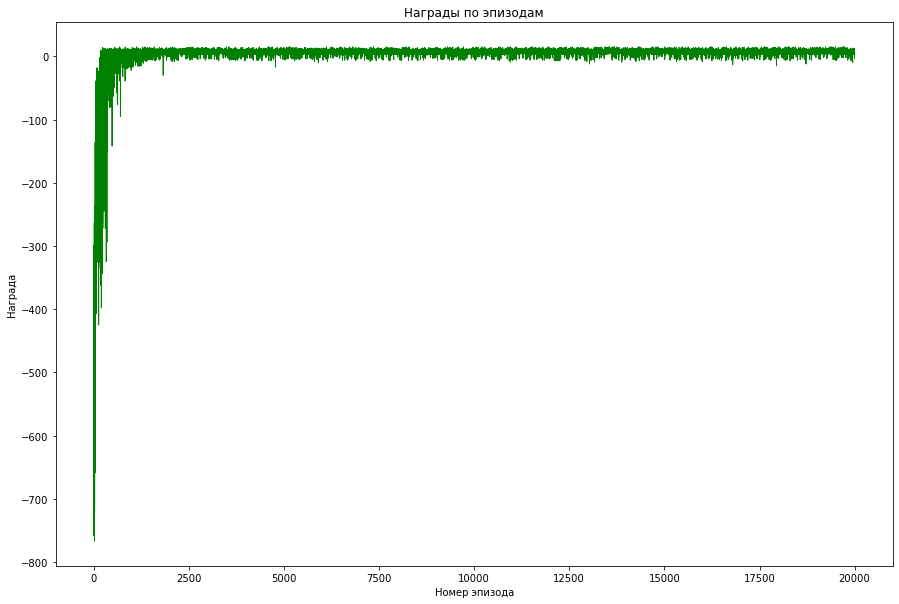

In [12]:
run_sarsa(eps=0.1, lr=0.3, gamma=0.96)

#### Вывод
В результате подбора гиперпараметров для алгоритма временных различий SARSA было получено, что лучшим вариантом является набор:
- eps = 0.1
- lr = 0.3
- gamma = 0.96